# Problem 1

In [108]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time

In [109]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [110]:
# Load MNIST data
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [111]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [112]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', activation='tanh'))
    return model


In [113]:
# Discriminator
discriminator = build_discriminator()

# Generator
generator = build_generator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [114]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [115]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [116]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [117]:
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        gen_loss_sum = 0
        disc_loss_sum = 0
        batches = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_loss_sum += g_loss.numpy()
            disc_loss_sum += d_loss.numpy()
            batches += 1

        gen_losses.append(gen_loss_sum / batches)
        disc_losses.append(disc_loss_sum / batches)

        #generate_and_save_images(generator, epoch + 1, seed)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_and_save_images(generator, epochs, seed)
    return gen_losses, disc_losses

In [118]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [119]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss")
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss")
    plt.title("Training Losses per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Time for epoch 1 is 4.037674188613892 sec
Time for epoch 2 is 1.1692917346954346 sec
Time for epoch 3 is 1.1560051441192627 sec
Time for epoch 4 is 1.1888823509216309 sec
Time for epoch 5 is 1.2363331317901611 sec
Time for epoch 6 is 1.1952435970306396 sec
Time for epoch 7 is 1.1883466243743896 sec
Time for epoch 8 is 1.1810667514801025 sec
Time for epoch 9 is 1.1956770420074463 sec
Time for epoch 10 is 1.178825855255127 sec
Time for epoch 11 is 1.1763322353363037 sec
Time for epoch 12 is 1.219658613204956 sec
Time for epoch 13 is 1.1706187725067139 sec
Time for epoch 14 is 1.1910889148712158 sec
Time for epoch 15 is 1.184915542602539 sec
Time for epoch 16 is 1.200319528579712 sec
Time for epoch 17 is 1.1969900131225586 sec
Time for epoch 18 is 1.1939406394958496 sec
Time for epoch 19 is 1.1840457916259766 sec
Time for epoch 20 is 1.1878693103790283 sec
Time for epoch 21 is 1.2175087928771973 sec
Time for epoch 22 is 1.2333641052246094 sec
Time for epoch 23 is 1.1444716453552246 sec
Ti

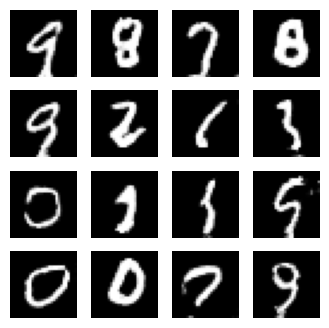

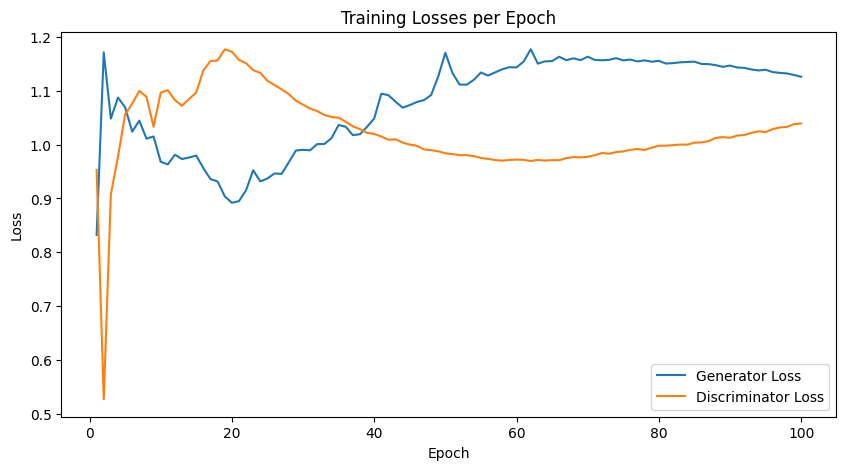

In [120]:
gen_losses, disc_losses = train(train_dataset, EPOCHS)
plot_losses(gen_losses, disc_losses)


# Problem 2

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
import time
import matplotlib.pyplot as plt


##Problem 2a

In [ ]:
def create_dqn_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_large(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_small(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape),
        layers.Dense(output_shape, activation=None)
    ])
    return model


##Problem 2b

In [ ]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


## Problem 2c

In [ ]:
from re import VERBOSE
BUFFER_SIZE = 256
GAMMA = 0.99

env = gym.make('MountainCar-v0')
buffer = ReplayBuffer(BUFFER_SIZE)

def get_action(state, epsilon, model):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        Q_values = model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(Q_values[0])


def update_dqn_network(model, optimizer, buffer, batch_size):
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = buffer.sample(batch_size)
    Q_targets_next = model.predict(next_state_batch, verbose=0).max(axis=1)
    Q_targets = reward_batch + (GAMMA * Q_targets_next * (1 - done_batch))

    with tf.GradientTape() as tape:
        Q_expected = model(state_batch)
        Q_expected_relevant = tf.reduce_sum(Q_expected * tf.one_hot(action_batch, 3), axis=1)
        loss = tf.keras.losses.MSE(Q_expected_relevant, Q_targets)

    gradients = tape.gradient(loss, model.trainable_variables)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [ ]:
NUM_EPISODES = 1000
EPISODE_SIZE = 500
BATCH_SIZE = 128
EPS_MAX = 1.0
EPS_DECAY = 0.995

model = create_dqn_model((2,), 3)  # or create_dqn_model_large, create_dqn_model_small
optimizer = tf.keras.optimizers.Adam()
rewards = []
epsilon = EPS_MAX

for episode in range(NUM_EPISODES):
    start_time = time.time()  # Start time measurement
    episodic_reward = 0
    state = env.reset()
    state = np.array(state[0], dtype=np.float32)

    for t in range(EPISODE_SIZE):
        action = get_action(state, epsilon, model)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        buffer.add(state, action, reward, next_state, done)
        episodic_reward += reward
        state = next_state

        if len(buffer) > BATCH_SIZE:
            update_dqn_network(model, optimizer, buffer, BATCH_SIZE)

        if done:
            break
    episode_duration = time.time() - start_time
    rewards.append(episodic_reward)
    epsilon *= EPS_DECAY
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Reward: {episodic_reward}, Time: {episode_duration:.2f} seconds")


plt.plot(rewards)
plt.title('Reward Curve')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()


Episode 1/1000, Reward: -500.0, Time: 25.49 seconds
Episode 2/1000, Reward: -500.0, Time: 29.57 seconds
Episode 3/1000, Reward: -500.0, Time: 28.46 seconds
Episode 4/1000, Reward: -500.0, Time: 29.83 seconds
Episode 5/1000, Reward: -500.0, Time: 28.79 seconds
Episode 6/1000, Reward: -500.0, Time: 29.28 seconds
Episode 7/1000, Reward: -500.0, Time: 28.24 seconds
Episode 8/1000, Reward: -500.0, Time: 29.18 seconds
Episode 9/1000, Reward: -500.0, Time: 28.80 seconds
Episode 10/1000, Reward: -500.0, Time: 30.56 seconds
Episode 11/1000, Reward: -500.0, Time: 29.54 seconds
Episode 12/1000, Reward: -500.0, Time: 31.04 seconds
Episode 13/1000, Reward: -500.0, Time: 29.42 seconds
Episode 14/1000, Reward: -500.0, Time: 30.88 seconds
Episode 15/1000, Reward: -500.0, Time: 29.67 seconds
Episode 16/1000, Reward: -500.0, Time: 31.46 seconds
Episode 17/1000, Reward: -500.0, Time: 30.69 seconds
Episode 18/1000, Reward: -500.0, Time: 31.60 seconds
Episode 19/1000, Reward: -500.0, Time: 30.49 seconds
Ep